<a href="https://colab.research.google.com/github/yanling-soz/yanling.github.io/blob/gh-pages/Predict_Covid_%23Cases_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DS 100 Final Project: Explore Covid-19 Data Set**
---
#### **Author: Yanling Liu**

In this final project, we will be using some Covid-19 data sets and linear regression to explore two main questions:

1. What happens if we try to use known features to predict the number of confirmed cases of each *state* on a given day? Is it a conductable way for the future to predict number of confirmed cases of a state on a given day given the available features?
2. What are the best features to use in order to predict the number of confirmed cases of each *county* on a given day? What different combinations of features are there to give an ideal result? 

#### **Set Up**

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Model Building
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.base import clone

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer

In [ ]:
# Graph Plotting
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

from plotly.offline import iplot
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Part I: Modeling Daily Number of Confirmed Cases for a State**
**Question to focus on: Can we model the number of confirmed cases on a given day of each state? If so, what are the best features to use?**

Suppose we do not know the number of confirmed cases on a given day for each state, is it possible to use some known data of a particular day to help us predict?
We will be using Covid-19 data set of each state on May 7th State_05_07 from Github. We decide to use a data set later in time because it is more updated and contains relatively more information that hopefully will help the analysis.

#### **Step 1: Obtaining the Data**
We first load the Covid-19 data set of each state on May 7th State_05_07 from Github and name the table *State_05_07*

In [ ]:
State_05_07_Url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/05-07-2020.csv"
State_05_07 = pd.read_csv(State_05_07_Url)
State_05_07.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-05-08 02:32:36,32.3182,-86.9023,9046,369,NaN,8677.0,1,192.923837,115173.0,1178.0,4.079151,84000001,USA,2456.291959,13.022330
1,Alaska,US,2020-05-08 02:32:36,61.3707,-152.4044,374,10,291.0,73.0,2,62.568068,24341.0,NaN,2.673797,84000002,USA,4072.110535,NaN
2,American Samoa,US,2020-05-08 02:32:36,-14.2710,-170.1320,0,0,NaN,0.0,60,0.000000,83.0,NaN,NaN,16,ASM,149.170576,NaN
3,Arizona,US,2020-05-08 02:32:36,33.7298,-111.4312,9945,450,1722.0,7773.0,4,136.631222,111086.0,1449.0,4.524887,84000004,USA,1526.175561,14.570136
4,Arkansas,US,2020-05-08 02:32:36,34.9697,-92.3731,3703,87,2123.0,1493.0,5,143.026705,59995.0,462.0,2.349446,84000005,USA,2317.279812,12.476371


In [ ]:
# Checking how many (rows, columns) State_05_07 has
State_05_07.shape

(58, 18)

From reading explanations of each variables in the data set, we think these listed variables are likely to have an impact on number of confirmed cases on a given day: *Lat, Long_, Incident_Rate, People_Tested, People_Hospitalized, Testing_Rate, Hospitalization_Rate, Mortality_Rate*. We will extract a table frame *State_05_07_Selected*, which contains these columns that we are interested in.

Because there is a direct relationship between *Active, Confirmed, Recovered and Deaths(Active = Confirmed - recovered - deaths)*, we do not take any of the above variables into predicting the number of confirmed cases. In addition, *Incident_Rate* is number of confirmed cases per 100,000 people. Since *Incident_Rate* is directly related to *Confirmed*, we will not take *Incident_Rate* into designing our model.

In [ ]:
State_05_07_Selected = State_05_07[['Province_State', "Confirmed", 'Lat', 'Long_', "People_Tested", 
                                    "People_Hospitalized", "Testing_Rate", "Hospitalization_Rate", 'Mortality_Rate']]
State_05_07_Selected.head()

,Province_State,Confirmed,Lat,Long_,People_Tested,People_Hospitalized,Testing_Rate,Hospitalization_Rate,Mortality_Rate
0,Alabama,9046,32.3182,-86.9023,115173.0,1178.0,2456.291959,13.022330,4.079151
1,Alaska,374,61.3707,-152.4044,24341.0,NaN,4072.110535,NaN,2.673797
2,American Samoa,0,-14.2710,-170.1320,83.0,NaN,149.170576,NaN,NaN
3,Arizona,9945,33.7298,-111.4312,111086.0,1449.0,1526.175561,14.570136,4.524887
4,Arkansas,3703,34.9697,-92.3731,59995.0,462.0,2317.279812,12.476371,2.349446


#### **Step 2: Prepare the Data(NAN values, Visualization, Train-Test Split)**
In Step 2, we will find missing values in *State_05_07_Selected* and try to address them in a logical way. Moreover, We will visualize our data after dealing with null values. In the end, we will prepare our training and testing set using Train-Test Split techniques.

##### **Missing Values**
We will first check for missing values in the *State_05_07* and determine what to do with missing values if they exist.

In [ ]:
# Compute the number of null value in our data set
State_05_07_Selected.drop('Province_State', axis = 1).isnull().sum()

Confirmed                0
Lat                      2
Long_                    2
People_Tested            2
People_Hospitalized     26
Testing_Rate             2
Hospitalization_Rate    26
Mortality_Rate           1
dtype: int64

There are 26 missing values in People_Hospitalized and Hospitalization_Rate, which is almost half of number of states in the data set. According to the spec of the data set, "the 'hospitalization rate' and 'hospitalized - Cumulative"'data is only presented for those states which provide cumulative hospital data". We do not think substituting missing values People_Hospitalized and Hospitalization_Rate to be 0 is a good idea as this may largely affect our analysis. Therefore, we will drop these two variables for now.

In [ ]:
# Drop columns 'People_Hostpitalized' and 'Hospitalization_Rate
State_05_07_Selected = State_05_07_Selected.drop(['People_Hospitalized', 'Hospitalization_Rate'], axis = 1)

There are also many columns that have exactly 2 missing values, so let's see where they come from.

In [ ]:
# Locate the 2 missing values in column 'Lat'
Latitude = State_05_07_Selected[['Lat']].to_numpy()
Lat_NA_Idx = np.argwhere(np.isnan(Latitude.flatten()))
State_05_07_Selected.loc[Lat_NA_Idx.flatten(), ]

,Province_State,Confirmed,Lat,Long_,People_Tested,Testing_Rate,Mortality_Rate
9,Diamond Princess,49,NaN,NaN,NaN,NaN,0.000000
13,Grand Princess,103,NaN,NaN,NaN,NaN,2.912621


The two columns above account for missing values in *Lat, Long_, People_Test* and *Testing_Rate*. However, neither of the rows above has missing values in *Mortality_Rate*, and we should find out where that missing value is.

In [ ]:
# Locate the row with missing value in Mortality Rate
Mortality_Rate = State_05_07_Selected[['Mortality_Rate']].to_numpy()
MR_NA_Idx = np.argwhere(np.isnan(Mortality_Rate.flatten()))
State_05_07_Selected.loc[MR_NA_Idx.flatten(), ]

,Province_State,Confirmed,Lat,Long_,People_Tested,Testing_Rate,Mortality_Rate
2,American Samoa,0,-14.271,-170.132,83.0,149.170576,NaN


The 2 missing values that exist in majority of the columns come from Diamond Princess and Grand Princess, which are cruises that had passengers tested positive for the coronavirus. Because cruise ships are not very comparable to states and have many missing values in its attributes, we decide to remove Diamond Princess and Grand Princess from our data set and we will name the cleaned data set *State_05_07_Cleaned*.

In [ ]:
# Drop Diamond Princess and Grand Princess from the data set.
State_05_07_Cleaned = State_05_07_Selected.drop(Lat_NA_Idx.flatten(), axis = 0)

The 1 missing value in *Mortality_Rate* comes from American Samoa column. This column contains no confirmed cases and 4 missing values. Since there is too little information provided for American Samoa, we decide to remove it from our data set as well.

In [ ]:
# Drop American Somoa from the data set
State_05_07_Cleaned = State_05_07_Cleaned.drop(MR_NA_Idx.flatten(), axis = 0)

##### **Fun Visualizations**

Now that we have a cleaned data set *State_05_07_Cleaned*, let us do a fun visualization which is inspired by visualizations in our beloved Project 1 :)

The graph we are attemping to make is a geospacial visualization for number of confirmed cases in the US on May 7th.

In [ ]:
# Uploading the base map which is name geo_us_map_1 (3)
from google.colab import files 
from IPython.display import Image
uploaded = files.upload()

When attempting to obtain the minimum and maximum coordinates of *State_05_07_Cleaned*, we find outliers in longitute that are extremely large in values. For example, islands like Northern Mariana Islands(row displayed below) that has extremely large longitute values that messes up with the plot. Therefore we will Borrowing min/man longitute and latitude values from abridged_counties.csv, a data set containing information for counties in the US. We have not used this data set yet but we will in later sections.

In [ ]:
# Locate where the maximum longitute in State_05_07_Cleaned is
State_05_07.loc[State_05_07['Long_'] == max(State_05_07['Long_'])]

In [ ]:
# Modified from codes in DS100 Project 1b
# Obtain the data to plot
State_Fig = State_05_07_Cleaned[['Long_', 'Lat', 'Confirmed']]

# Borrowing min/man longitute and latitude values from abridged_counties.csv 
# Set up axis of the plot
min_lon = -124.13544840000002 
max_lon = -67.64576098 
min_lat = 25.53393405 
max_lat = 48.82053446 
max_cases = State_Fig['Confirmed'].max()
min_cases = State_Fig['Confirmed'].min()
bound = ((min_lon, max_lon, min_lat, max_lat))
min_lon, max_lon, min_lat, max_lat
map_bound = ((min_lon-4.5, max_lon+4, min_lat-5, max_lat+3.5))

# Obtain the base map and set up the subplot
basemap = plt.imread('geo_us_map_1 (3).png')
fig, ax = plt.subplots(figsize = (20,20))
ax.set_xlim(map_bound[0],map_bound[1])
ax.set_ylim(map_bound[2],map_bound[3])

# Create the hexbin plot
plt.hexbin(x=State_Fig['Long_'].to_list(), 
           y=State_Fig['Lat'].to_list(), 
           C=State_Fig['Confirmed'],reduce_C_function=np.mean,gridsize=80, cmap='Reds')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Geospatial Plot of #Cases of States in the US (May 7th 2020)')
plt.colorbar(fraction=0.046, pad=0.04, shrink =0.5).set_label('# Covid-19 Cases')

# Set aspect ratio and plot the hexbins on top of the base map layer
ax.imshow(basemap, zorder=0, extent = map_bound, aspect= 'equal');

In this geospacial visualization of number of confirmed Covid-19 cases for states in the United States on May 7th, we can see that Northeast of the US has the most confirmed cases, especially area near NY. We can see that color code gets lighter as we go in towards the middle of the United States, indicating more cases on the outskirt states and less in the middle of the US. Therefore we can see that geographics somewhat show patterns in number of confirmed cases and geographical indicators should maybe be considered in our future model.

##### **Train Test Split**
We will now complete the preparation process by splitting *State_05_07_Cleaned* into 83% training set and 17% testing set with *randam_state* = 107.

In [ ]:
# Train test split
State_Train, State_Test = train_test_split(State_05_07_Cleaned, test_size=0.17, random_state=107)
print("State Training Data Size: ", len(State_Train))
print("State Test Data Size: ", len(State_Test))

#### **Step 3: Linear Regression Model(SKLearn Pipelines)**

##### **Functions: Assess Accuracy of Models(RMSE, Cross Validation)**
*The functions defined in this section will also be used for other data set analysis.*

In order to assess the performance of our model, we will compute root mean square error(RMSE) R^2 as some indicators. RMSE will tell us how big are the mistakes using our models to predict number of cases. R^2 will tell us how much variance are being explained by the selected features in the model. 

Below we will defind a function *Rmse()* for calculating RMSE between actual number of cases on May 7th, *Y*, and predicted number of cases, *Y_Predicted*.

In [ ]:
# Function to compute rmse
def Rmse(Y, Y_Predicted):
    return np.sqrt(np.mean((Y - Y_Predicted)**2))

We will use cross validation to help us estimate the rmse value of the test set. The functiond defined below, *CV_Rmse()* takes in a model, a training set, the actual *Y* values, performs N fold cross validation(the default of the function is 5 fold), and returns the average rmse.

In [ ]:
# Function to compute cross validation rmse
def CV_Rmse(Model, Train, Y, NFold = 5):
    Model = clone(Model)
    N_Fold = KFold(n_splits= NFold)
    Rmse_Val = []
    for Train_Idx, Val_Idx in N_Fold.split(Train):
        Model.fit(Train.iloc[Train_Idx,:], Y.iloc[Train_Idx])
        Rmse_Val.append(Rmse(Y.iloc[Val_Idx], Model.predict(Train.iloc[Val_Idx,:])))
    return np.mean(Rmse_Val)

##### **Build Pipelines**

Because we would like to find out how many of existing features we should use to have the best predictions, we need to compare outcomes of different models. Therefore we will set up a pipeline below to make the process easier.


The value ranges of the features in State_05_07_Cleaned differ from each other. Therefore it would be helpful if we normalize the data. We will use the *StandardScaler* function from sklearn.

In [ ]:
# A dictionary to record our state models
State_Linear_Models = {}

# Build the pipeline
def Assess(Train, X_Columns, Y, Model_Abrv, Model_List, CV_NFold):
  Model = Pipeline([
                    ("PickColumns", ColumnTransformer([("keep", "passthrough", X_Columns)])),
                    ("Scale", StandardScaler()), 
                    ("LinearModel", LinearRegression())
                    ])
  Model.fit(Train, Y)
  Y_Predicted = Model.predict(Train)
  # Return the rmse of the given model predicting on traning set
  print("Training Error (RMSE): ", Rmse(Y, Y_Predicted))
  # Return the cross validation rmse of the given model predicting on traning set
  print("Cross Validation Error : ", CV_Rmse(Model, Train, Y, CV_NFold))
  # Return the R^2 value of the given model predicting on traning set
  print("R Square Training: ", Model.score(Train, Y))
  # Save the model to list of models
  Model_List[Model_Abrv] = Model

#### **Step 4: Select Features & Assess Models**

In this step, we will try to select related features that can help predict number of cases of each state on May 7th. We will fit the model with selected features and see how they perform.

##### **Feature Selection 1: People_Tested**

*People_Tested*: The number of people tested in each state. We should expect if there are more people tested in a state, there will be more confirmed cases in a state because more people potentially could be discovered to be confirmed cases.

In [ ]:
# Set Y value
Y = State_Train['Confirmed']
# Select feature columns
X_Columns = ['People_Tested']
# Name of the model
Model_Abrv = 'PT'
# Assess the model
Assess(State_Train, X_Columns, Y, Model_Abrv, State_Linear_Models, 5)

The R^2 of this model is large, which means *People_Tested* explains most of the variances of our data. However, the training rmse and cross validation rmse are both really large even after we standardize the data. 

Will fitting more features help reduce the errors? We will keep selecting desired features and compared the models in the end.

##### **Feature Selection 2: People_Tested, Testing_Rate**

In [ ]:
# Select feature columns
X_Columns = ['People_Tested', 'Testing_Rate']
# Name of the model
Model_Abrv = 'PT, TR'
# Assess the model
Assess(State_Train, X_Columns, Y, Model_Abrv, State_Linear_Models, 5)

##### **Feature Selection 3: People_Tested, Testing_Rate, Lat, Long_**


In [ ]:
# Select feature columns
X_Columns = ['People_Tested', 'Testing_Rate', 'Lat', 'Long_']
# Name of the model
Model_Abrv = 'PT, TR, Lat+Long'
# Assess the model
Assess(State_Train, X_Columns, Y, Model_Abrv, State_Linear_Models, 5)

##### **Feature Selection 4: People_Tested, Testing_Rate, Lat, Long_, Mortality_Rate**

In [ ]:
# Select feature columns
X_Columns = ['People_Tested', 'Testing_Rate', 'Lat', 'Long_', 'Mortality_Rate']
# Name of the model
Model_Abrv = 'PT, TR, Lat+Long, MR'
# Assess the model
Assess(State_Train, X_Columns, Y, Model_Abrv, State_Linear_Models, 5)

##### **Feature Selection 5: People_Tested, Testing_Rate, Mortality_Rate**

In [ ]:
# Select feature columns
X_Columns = ['People_Tested', 'Testing_Rate', 'Mortality_Rate']
# Name of the model
Model_Abrv = 'PT, TR, MR'
# Assess the model
Assess(State_Train, X_Columns, Y, Model_Abrv, State_Linear_Models, 5)

We tried 5 combinations of features that could help us predict daily number of cases in each state. As we can see so far, the error does not reduce by much no matter what features we use, but R^2 does increases as more features are fitted. In order to better compare the performance of each model, we will create plotting function that gives us better visualization and makes comparing easier.

##### **Compare Models**

We will compare the performance of the state models we have so far. Below we define function *Compare_M()* that takes in a dictionary of models, a training data set, actual *Y* values of the training data set, and it will plot training rmse, cross validation rmse, and R^2 of each model in the model list. *CV_N* fold cross validation is performed in the process.

In [ ]:
# Model Comparing Function
def Compare_M(Models, Train, Y, CV_N):
    # Compute the training rmse for each model
    Train_Rmse = [Rmse(Y, m.predict(Train)) for m in Models.values()]
    # Compute the cross validation error for each model
    Validation_Rmse = [CV_Rmse(m, Train, Y, CV_N) for m in Models.values()]
    # Compute the R Square for each model
    R_Square = [m.score(Train, Y) for m in Models.values()]

    labs = list(Models.keys())
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Bar(x = labs, y = Train_Rmse, name="Training RMSE"),
        secondary_y = False
        )
    fig.add_trace(
        go.Bar(x = labs, y = Validation_Rmse, name="CV RMSE"),
        secondary_y = False
    )
    fig.add_trace(
        go.Scatter(x = labs, y = R_Square, name = "R^2"),
        secondary_y = True,
        )
    fig.update_xaxes(title="Model Abbreviations")

    fig.update_yaxes(title_text="RMSE", secondary_y=False)
    fig.update_yaxes(title_text="R^2", secondary_y=True)
    return fig

In [ ]:
# Comparing models in State_Linear_Models
fig = Compare_M(State_Linear_Models, State_Train, Y, 5)
fig.update_layout(
    title_text = "Compare Models for Predicting # of Cases of a State on May 7"
)

By fitting all 5 feature columns in the data set *People_Tested, Testing_Rate, Lat, Long_, Mortality_Rate*, we are able to maximize R^2, which means all 5 features explain the most variances of our data. 

The RMSE and CV remain huge as more features are used. But the errors do reduce with more features used. However, the value of errors are around 30k to 40k, which indicates the models are not as ideal. 
Recall the geospacial plot for number of cases in each state on May 7th, the value of confirmed cases in the United States has a wide range from around 5000 to around 30k. Therefore, we suspect that there are outliers that resulf in huge prediction errors.


With limited amount of featues of each state, predicting number of cases of each state on a given day seems harder than expected. As counties have more available features, we wonder what will happen if we try to predict the number of cases in a county based on available information? Would the results be better than predicting based on states? What are the best feature to use to predict number of cases of a county on a given day?

### **Part II: Best Features for a County**
**Question to focus on: Can we predict the number of cases in a county based on the data that we have?**

In Part II, we will use data in *abridged_counties.csv* and *time_series_covid19_confirmed_US*. *abridged_counties.csv* contains many features of counties in the US, and *time_series_covid19_confirmed_US* contains number of confirmed cases of each county from January 22, 2020 to a recent date. 

#### **Step 1: Obtain and Combine the Data, Adress Null**

We will obtain the most recent *time_series_covid19_confirmed_US* at the time we are working on the project. The latest date in the data set is May 10th, 2020. And we will use features in *abridged_counties.csv* to predict number of cases for each county on May 10th.

##### **Obtain the Data**

In [ ]:
# Obtain time_series_covid19_confirmed_US, saved as County_Confirmed
County_Confirmed_Url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
County_Confirmed = pd.read_csv(County_Confirmed_Url)
County_Confirmed.head()

In [ ]:
# Check (#rows, #cols) of County_Confirmed
County_Confirmed.shape

We want to predict the number of cases of a county on May 10th, and therefore we would like to only keep the most recent 40 days of # of confirmed cases data in our *County_Confirmed* data set. We will also keep column *FIPS* because it will help us combine tables later.

In [ ]:
# Extract #confirmed cases data from 4/1/20 to 5/10/20 by indexing the desired columns
County_Confirmed = County_Confirmed.iloc[:, np.append(4, np.arange(81, 121))]

In [ ]:
# Obtain abridged_counties.csv, saved as County_Info
County_Info_Url = "https://raw.githubusercontent.com/Yu-Group/covid19-severity-prediction/master/data/county_data_abridged.csv"
County_Info = pd.read_csv(County_Info_Url)
County_Info.head()

##### **Address some Null Values**

In [ ]:
#Functions for checking on null values and dropping null columns
def Inspect_Null(df, col):
  col = df[[col]].to_numpy()
  NA_Idx = np.argwhere(np.isnan(col.flatten()))
  return df.loc[NA_Idx.flatten(), ]

def Drop_Null(df, col):
  col = df[[col]].to_numpy()
  NA_Idx = np.argwhere(np.isnan(col.flatten()))
  df = df.drop(NA_Idx.flatten(), axis = 0)
  return df

###### ***County_Confirmed* Table**

In [ ]:
# Check on columns in Cunty_Confirmed that has missing FIPS
Inspect_Null(County_Confirmed, "FIPS").head()

In [ ]:
# Becasuse we cannot tell what counties the data with missing FIPS is indicating, we decide to drop the above columns.
County_Confirmed = Drop_Null(County_Confirmed, "FIPS")

###### ***County_Info* Table**

In [ ]:
# Checking null value counts in County_Info
County_Info.info()

We see a some columns have less than 1000 non-null values. Most of these columns with many missing values are mortality rates. It would be not reasonable to substitute counties' mortality rates with counties' average mortality rates because there are too many missing values. Therefore we decide to drop those columns.

In [ ]:
# Drop columns that have <= 1000 non-null values
County_Info = County_Info.drop(['3-YrMortalityAge<1Year2015-17', '3-YrMortalityAge1-4Years2015-17', 
                                '3-YrMortalityAge5-14Years2015-17', '3-YrMortalityAge15-24Years2015-17', 
                                '3-YrMortalityAge25-34Years2015-17', 'mortality2015-17Estimated'], axis = 1)

Another thing to notice is the two FIPS at the bottom of the data set are 'City1' and 'City2', which are abnormal *FIPS* values and we will drop them from the data set.

In [ ]:
# Drop the last two rows, city 1 and city 2 at the bottom, as they are not identifiable
County_Info = County_Info.drop([3242, 3243], axis = 0)

##### **Combine Two Data Sets**

We notice that one way to combine two tables is through columns that contain "FIPS" (Federal Information Processing Standards). FIPS is publicly announced standards developed by the National Institute of Standards and Technology for use in computer systems by non-military American government agencies and government contractors. Each county has an unique FIPS, and therefore we can combine rows that have the same FIPS indicated by *FIPS* in *County_Confirmed* and *countyFIPS* in *County_Info*.


In [ ]:
# Inspecting type of FIPS in each df
print(type(County_Info['countyFIPS'][0]), type(County_Confirmed['FIPS'][0]))

In [ ]:
# Convert both FIPS to int
County_Confirmed['FIPS'] = County_Confirmed['FIPS'].apply(int)
County_Info['countyFIPS'] = County_Info['countyFIPS'].apply(int)

We will perform Inner Join on the two tables because we only want counties that have FIPS in both df to remain. We will name the new combined data set *CIC*.

In [ ]:
# Inner join
CIC = pd.merge(left = County_Info, right = County_Confirmed, left_on = 'countyFIPS', right_on = 'FIPS').drop('FIPS', axis = 1)
CIC.info()

In [ ]:
CIC.head()

##### **Redundant Columns and Null Values in CIC**

###### **Drop Redundant Columns**

In the newly formed table, *CIC*, column *STATEFP* is state FIPS code, so *StateName* and *State* are columns with redundant information and we will drop them. Column *COUNTYFP* is county FIPS code, which is part of FIPS of each county, and therefore we will drop *COUNTYFP* as well.

In [ ]:
# Drop redundance columns
CIC = CIC.drop(['StateName', 'State', 'COUNTYFP'], axis = 1)
CIC.info()

###### **More Null Values in CIC**
Let us start from inspecting counties that have missing latitues.

In [ ]:
# Inspecting the rows that do not have latitude
Lat_Null = Inspect_Null(CIC, 'lat')
# (nrow, ncol) of Lat_Null
Lat_Null.shape

In [ ]:
# Inspect which census division do these rows belong to
Lat_Null['CensusDivisionName'].unique()

In [ ]:
# Counting values of number of cases of Lat_Null
Lat_Null['5/10/20'].value_counts()

Name of census division of counties that do not have coordinates is either 'Pacific' or 'South Atlantic'. Since there are only 15 out of 66 counties in Lat_Null has 0 cases on 5/10/20 and most of these counties still have confirmed cases on 5/10/20, we would like to keep these rows and fill in its coordinates with average coordinates of counties in its census devision.

In [ ]:
# Obtain average of latitude and longitude of both Pacific and South Atlantic census division.
latP, lonP = CIC.loc[CIC['CensusDivisionName'] == 'Pacific'][['lat', 'lon']].mean(skipna=True)
latSA, lonSA = CIC.loc[CIC['CensusDivisionName'] == 'South Atlantic'][['lat', 'lon']].mean(skipna=True)
# Replace null values in lat and lon
CIC.loc[(CIC['CensusDivisionName'] == 'Pacific') & (CIC['lat'].isnull()), 'lat'] = latP
CIC.loc[(CIC['CensusDivisionName'] == 'Pacific') & (CIC['lon'].isnull()), 'lon'] = lonP
CIC.loc[(CIC['CensusDivisionName'] == 'South Atlantic') & (CIC['lat'].isnull()), 'lat'] = latSA
CIC.loc[(CIC['CensusDivisionName'] == 'South Atlantic') & (CIC['lon'].isnull()), 'lon'] = lonSA

The columns *3-YrMortalityAge35-44Years2015-17* and *3-YrDiabetes2015-17* both have more than half of values missing. We do not think it is wise to replace more than half of column with the mean of the rest of the column, so we decide to drop these two columns.

In [ ]:
# Drop columns that have more than half of values missing
CIC = CIC.drop('3-YrMortalityAge35-44Years2015-17', axis = 1).drop('3-YrDiabetes2015-17', axis = 1)

In [ ]:
# Count missing values for columns that still have NAN values
NA_Col = CIC[CIC.columns[CIC.isnull().any()]]
NA_Col.isnull().sum()

Most mortality rates have many missing values, and we decide to substitute them with mean values of each column because we believe mortality rate should be closely related to medical condition in a county that could affect number of confirmed cases. 

We will replace missing values in all rest of the columns with mean value of existing data, because the number of missing values is small compared to the data size.

In [ ]:
# Get index of all columns that still have missing values
cols = NA_Col.isnull().sum().index.array

# Mean_Replace_Null() replaces columns with indexes in cols in the dataframe df with mean values of the corresponding column
def Mean_Replace_Null(df, cols):
  for i in np.arange(len(cols)):
    col = cols[i]
    mean = df[[col]].mean(skipna=True)[0]
    df.loc[(df[col].isnull()), col] = mean

# Replace rest of null values in CIC with mean
Mean_Replace_Null(CIC, cols)
CIC.info()

#### **Step 2: Further Preparation (Categorical Variables, Train Test Split, Address Outlier)**

In step 2, we will furture prepare the data set *CIC*.

##### **Categorical Variables: One Hot Encoding**

We notice that columns *CensusRegionName* and *CensusDivisionName* both contain categorical variables. We will use one hot encoding to address these two columns.

In [ ]:
# Values in CensusRegionName
CIC['CensusRegionName'].unique()

In [ ]:
# Values in CensusDivisionName
CIC['CensusDivisionName'].unique()

We will define the function *Ohe()*, which perform one hot encoding to columns in *cols* in the dataframe *df*

In [ ]:
# Modified from codes in hw6
# Function for one hot encoding
def Ohe(df, cols):
    """
    One-hot-encodes columnes in dataframe df.
    """
    vectorizer = DictVectorizer()
    for col in cols:
      vectorizer.fit(df[[col]].to_dict(orient='records'))
      col_data = vectorizer.transform(df[[col]].to_dict(orient='records')).toarray()
      col_names = vectorizer.get_feature_names()
      col = pd.DataFrame(col_data, columns=col_names)
      df = pd.concat([df, col], axis=1)
    return df

# Perform OHE on related columns in CIC
CIC = Ohe(CIC, ['CensusRegionName', 'CensusDivisionName'])
CIC.head()

In [ ]:
# Rearrange columns so that related information are close to each other
cols = CIC.columns.tolist()
rearrange = cols[:3] + cols[7:9] + cols[116:] + cols[3:7] + cols[9:116]
CIC = CIC[rearrange]
CIC.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3140 entries, 0 to 3139
Data columns (total 129 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   countyFIPS                             3140 non-null   int64  
 1   STATEFP                                3140 non-null   float64
 2   CountyName                             3140 non-null   object 
 3   CensusRegionName                       3140 non-null   object 
 4   CensusDivisionName                     3140 non-null   object 
 5   CensusRegionName=Midwest               3140 non-null   float64
 6   CensusRegionName=Northeast             3140 non-null   float64
 7   CensusRegionName=South                 3140 non-null   float64
 8   CensusRegionName=West                  3140 non-null   float64
 9   CensusDivisionName=East North Central  3140 non-null   float64
 10  CensusDivisionName=East South Central  3140 non-null   float64
 11  Cen

After cleaning the data, as we can see from the above info table, the 0-4th columns are basic categorical information about each county that we will not fit in our model. The 5th to 17th columns are one hot encoding results of categorical variables 'CensusRegionName' and 'CensusDivisionName'. The 18th to 88th columns are other numerical features of each county. Finally the 89th to 128th columns are the number of confirmed cases on each day from April 1st 2020 to May 10th 2020.

##### **Train Test Split**

In [ ]:
# Split CIC into training and test set
County_Train, County_Test = train_test_split(CIC, test_size = 0.1, random_state = 107)
print("Training Data Size: ", len(County_Train))
print("Test Data Size: ", len(County_Test))

Training Data Size:  2826
Test Data Size:  314


##### **Potential Outliers**
We will see if our data has obvious outliers and try to address them if they exist.

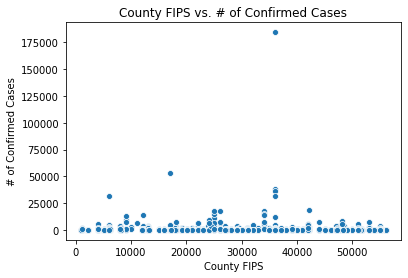

In [ ]:
# Visualize the training data
sns.scatterplot(x='countyFIPS', y='5/10/20', data=County_Train)
plt.title("County FIPS vs. # of Confirmed Cases")
plt.xlabel("County FIPS")
plt.ylabel("# of Confirmed Cases");

There is an outlier with # confirmed cases above 175k and we may want to remove it because it is too much bigger than the rest of the data set. Let us see where this outlier come from.

In [ ]:
# Locate the outlier
County_Train.loc[County_Train['5/10/20'] > 175000]['CountyName']

1849    New York
Name: CountyName, dtype: object

The outlier in our training set is New York. New York has had the most # of confirmed cases in the US and the difference between NY and the rest of counties is very significant. We will remove New York from the training set because no other counties in the training set has similar situation.

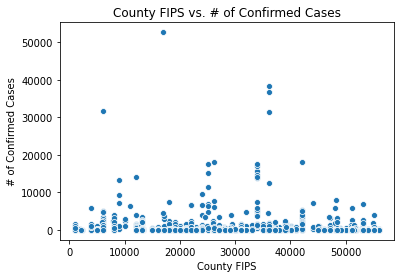

In [ ]:
# Remove New York
NY_Index = County_Train.loc[County_Train['5/10/20'] > 175000].index[0]
County_Train = County_Train.drop([NY_Index], axis=0)

# Visualize training set after removing NY
sns.scatterplot(x='countyFIPS', y='5/10/20', data=County_Train)
plt.title("County FIPS vs. # of Confirmed Cases")
plt.xlabel("County FIPS")
plt.ylabel("# of Confirmed Cases");

#### **Step 3: Select Features, Fit Models**

Finally, we are done with cleaning and preparing our data sets!
In step 3, we will select relevant features to design linear regression models that predict the number of cases in each county on May 10th, 2020.

##### **Step 3.0 : Fun GeoSpacial Visual of Training Set**
We will plot visualization of # of confirmed Covid-19 cases of each county on May 10th as we did for states' data.

In [ ]:
# Relevant Columns
CIC_Coord_NCases = CIC[['lon', 'lat', '5/10/20']].head()

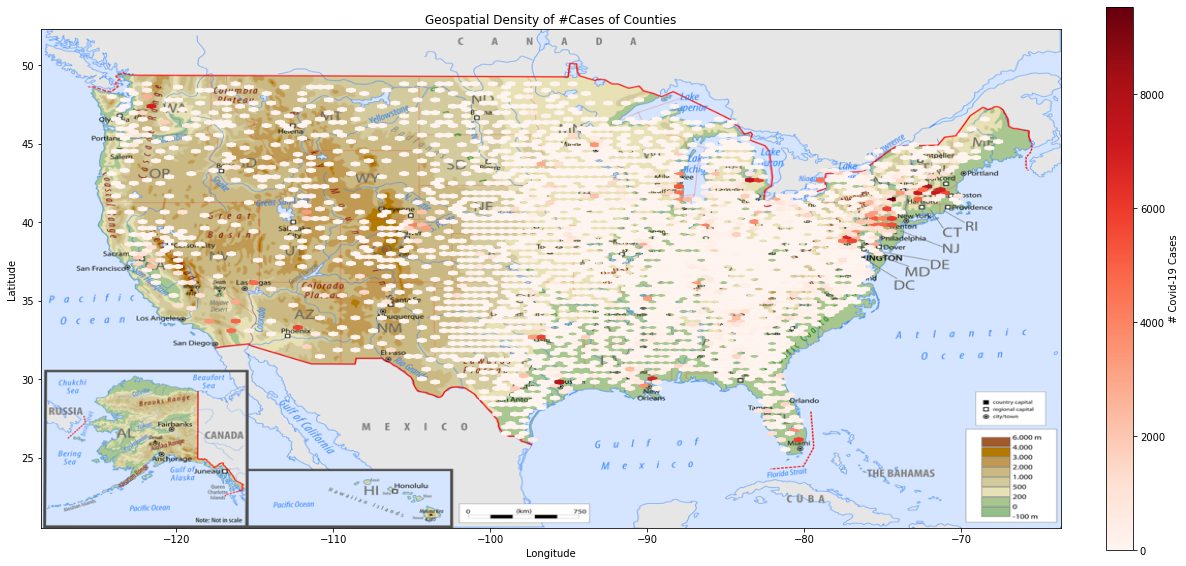

In [ ]:
# Modified from codes in by Project 1b
## Only plotting counties with #cases smaller than 10000 
# because there are a small amount of large values that make the visualizations less clear.
CIC_10000 = CIC.loc[CIC['5/10/20'] <= 10000]

# Set coordinates boundaries and axis
min_lon = CIC_10000['lon'].min()
max_lon = CIC_10000['lon'].max()
min_lat = CIC_10000['lat'].min()
max_lat = CIC_10000['lat'].max()
max_cases = CIC_10000['5/10/20'].max()
min_cases = CIC_10000['5/10/20'].min()
bound = ((min_lon, max_lon, min_lat, max_lat))
min_lon, max_lon, min_lat, max_lat
map_bound = ((min_lon-4.5, max_lon+4, min_lat-5, max_lat+3.5)) 
#Tried different values and keeping the values that makes the plot fit well with the basemap

# Obtain the base map and set up the subplot
basemap = plt.imread('geo_us_map_1.png')
fig, ax = plt.subplots(figsize = (20,20))
ax.set_xlim(map_bound[0],map_bound[1])
ax.set_ylim(map_bound[2],map_bound[3])

# Create the hexbin plot
plt.hexbin(x=CIC_10000['lon'].to_list(), 
           y=CIC_10000['lat'].to_list(), 
           C=CIC_10000['5/10/20'],reduce_C_function=np.mean,gridsize=100, cmap='Reds')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Geospatial Density of #Cases of Counties')
plt.colorbar(fraction=0.046, pad=0.04, shrink = 0.5).set_label('# Covid-19 Cases')

# Set aspect ratio and plot the hexbins on top of the base map layer
ax.imshow(basemap, zorder=0, extent = map_bound, aspect= 'equal');

The outcome of this graph is similar to the states plot as more counties with large amount of comfirmed cases are centered around New York, the east coast. With this graph, we are able to see some counties that have more cases than the surrounding counties in other areas of the US.

##### **Step 3.1: Geographical Identifiers**
In this part, we will explore how well geographical identifiers in our data set can predict the outcome.

In [ ]:
# Define Y values in our training set
Y_Tr_C = County_Train['5/10/20']
# Set up dictionary of county models
County_Models = {}

In the below code chunks, we will try different combinations of geographical identifiers in our dataset. The combinations will be named *GI1*, *GI2*, *GI3*, etc.

In [ ]:
#GI1 CensusRegionName, CensusDivisionName
# Select x columns by indexing
X_Columns = County_Train.columns.tolist()[5:18]
# Name of model that the columns will be fitted to
abr = 'GI1'
# Assess perfomance of the model
Assess(County_Train, X_Columns, Y_Tr_C, abr, County_Models, 10)

Training Error (RMSE):  2018.2930161580193
Cross Validation Error :  1811.9936107104145
R Square Training:  0.06648561960806143


In [ ]:
#GI2 CensusRegionName, CensusDivisionName, Coordinates
X_Columns = County_Train.columns.tolist()[5:20]
abr = 'GI2'
Assess(County_Train, X_Columns, Y_Tr_C, abr, County_Models, 10)

Training Error (RMSE):  2009.5710939647581
Cross Validation Error :  1807.3250077694204
R Square Training:  0.07453642995020549


In [ ]:
#GI3 CensusRegionName, CensusDivisionName, Coordinates, Population Coords 
X_Columns = County_Train.columns.tolist()[5:22]
abr = 'GI3'
Assess(County_Train, X_Columns, Y_Tr_C, abr, County_Models, 10)

Training Error (RMSE):  2008.8247486110631
Cross Validation Error :  1808.0972776133626
R Square Training:  0.0752237280242527


In [ ]:
#GI4 CensusRegionName, CensusDivisionName, Coordinates, Population Coords, Rural-Urban Continuum Code
X_Columns = County_Train.columns.tolist()[5:23]
abr = 'GI4'
Assess(County_Train, X_Columns, Y_Tr_C, abr, County_Models, 10)

Training Error (RMSE):  1980.9735914012242
Cross Validation Error :  1784.714712376472
R Square Training:  0.10068890903887995


In [ ]:
# Compare models with combinations of geographical indicators
fig = Compare_M(County_Models, County_Train, Y_Tr_C, 10)
fig.update_layout(
    title_text = "Compare Geographical Models for Predicting # of Cases of each County on May 10"
)

As we can see from the errors, the value of errors are much smaller than those in when predicting states. However, counties have smaller amount of confirmed cases, and that is probably why errors are much smaller. The R^2 of models containing only Geographical indicators remain low. The more features we fit, the higher R^2 values, but the errors are similar between models.

##### **Step 3.2: Demographics**
In this part, we will explore how much better models will perform when we add demographical indicators to geographical ones in our models.

In [ ]:
# Obtain name of demographical indicators by indexing
np.append(County_Train.columns.tolist()[23:26], County_Train.columns.tolist()[27])

array(['PopulationEstimate2018', 'PopTotalMale2017', 'PopTotalFemale2017',
       'PopulationEstimate65+2017'], dtype='<U25')

In the below code chunks, we will try different combinations of demographical indicators with exising geographical identifiers in our models. The models will be named DM1, DM2, DM3, etc.

In [ ]:
# DM1 Geo, Population(2018), Sex, 65+(2017), Census Pop(2010), MedianAge2010
# Obtain X columns
X_Columns_DM1 = np.append(np.append(County_Train.columns.tolist()[5:26], County_Train.columns.tolist()[27]), County_Train.columns.tolist()[29:31])
# Name of the model
abr = 'DM1'
# Assess the model
Assess(County_Train, X_Columns_DM1, Y_Tr_C, abr, County_Models, 10)
# Increased R^2 by a large amount, reduced rmse by a large amount as well

Training Error (RMSE):  1405.7877671421675
Cross Validation Error :  1487.405542012311
R Square Training:  0.5471106612181937


In [ ]:
# DM2 Geo, Population(2018), Sex, 65+(2017), Census Pop(2010), Pop Density 2010
X_Columns_DM2 = np.append(X_Columns_DM1, County_Train.columns.tolist()[28])
abr = 'DM2'
Assess(County_Train, X_Columns_DM2, Y_Tr_C, abr, County_Models, 10)

Training Error (RMSE):  1404.3287298794942
Cross Validation Error :  1522.4478881729272
R Square Training:  0.5480502618187508


In [ ]:
# DM3 Geo, Population(2018), Sex, 65+(2017), Census Pop(2010), Pop Density 2010, Medicare
X_Columns_DM3 = np.append(X_Columns_DM2, County_Train.columns.tolist()[31:33])
abr = 'DM3'
Assess(County_Train, X_Columns_DM3, Y_Tr_C, abr, County_Models, 10)

Training Error (RMSE):  1402.00424446197
Cross Validation Error :  1551.1901997659897
R Square Training:  0.5495451840584169


In [ ]:
# DM4 Geo, Population(2018), Sex, 65+(2017), Census Pop(2010), Pop Density 2010, Medicare, More demographical indicators(2010)
X_Columns_DM4 = np.append(X_Columns_DM3, County_Train.columns.tolist()[44:72])
abr = 'DM4'
Assess(County_Train, X_Columns_DM4, Y_Tr_C, abr, County_Models, 10)
## Increased R^2 by a lot, CV error increases, which indicates we may be overfitting
# However, Census Population in 2010 is directly correlated with the added demographical indicators based on cesus population in 2010.
# Therefore, we need to remove either Census Population or do not add the demographical indicators(2010).
# Let us see what happens without census population in 2010.

Training Error (RMSE):  1174.902450929198
Cross Validation Error :  1677.065514904553
R Square Training:  0.6836584799349048


In [ ]:
# DM5 DM4 without Census Pop(2010)
Census_Pop_Index = np.where(X_Columns_DM4 == 'CensusPopulation2010')[0][0]
X_Columns_DM5 = np.delete(X_Columns_DM4, Census_Pop_Index)
abr = 'DM5'
Assess(County_Train, X_Columns_DM5, Y_Tr_C, abr, County_Models, 10)
# The Results are similar, and the CV error indicates we still may be overfitting.

Training Error (RMSE):  1174.8321111541832
Cross Validation Error :  1677.7473363351824
R Square Training:  0.683696356654375


In [ ]:
# DM6 Try to fix problem of overfitting in DM5 by including only male indicators from 2010 census population
Census_Pop_Index = np.where(X_Columns_DM3 == 'CensusPopulation2010')[0][0]
X_Columns_DM6 = np.delete(X_Columns_DM3, Census_Pop_Index)
Male_Index = np.arange(44, 72, 2).astype(int)
X_Columns_DM6 = np.append(X_Columns_DM6, np.array(County_Train.columns.tolist())[Male_Index].tolist())
abr = 'DM6'
Assess(County_Train, X_Columns_DM6, Y_Tr_C, abr, County_Models, 10)
# Reduced CV error

Training Error (RMSE):  1246.212992117945
Cross Validation Error :  1580.5286332039975
R Square Training:  0.6440925108012872


In [ ]:
# DM7 Try to fix problem of overfitting in DM5/DM6 by including only age 45+ male indicators from 2010 census population
Census_Pop_Index = np.where(X_Columns_DM3 == 'CensusPopulation2010')[0][0]
X_Columns_DM7 = np.delete(X_Columns_DM3, Census_Pop_Index)
Male_Index = np.arange(60, 72, 2).astype(int)
X_Columns_DM7 = np.append(X_Columns_DM7, np.array(County_Train.columns.tolist())[Male_Index].tolist())
abr = 'DM7'
Assess(County_Train, X_Columns_DM6, Y_Tr_C, abr, County_Models, 10)
# Same result as above

Training Error (RMSE):  1246.212992117945
Cross Validation Error :  1580.5286332039975
R Square Training:  0.6440925108012872


In [ ]:
fig = Compare_M(County_Models, County_Train, Y_Tr_C, 10)
fig.update_layout(
    title_text = "Compare Geographical+Demographical Models for Predicting # of Cases of each County on May 10"
)

Add demographical indicators, both training rmse and cross validation rmse are reduced. Inaddition, R^2 values increase which means adding demographical indicators helps explain more variances in our data.

##### **Step 3.3: Health Outcomes and Risk Factors**

We will explore how much better models will perform when we add health outcome indicators and risk factors to existing features in our models. The model will be named *HO*.

In [ ]:
# HO Geo, DM6, Diabetes, Heart Disease, Stroke, Smokers, Age-standardized Mortality Rates
X_Columns = np.append(X_Columns_DM6, County_Train.columns.tolist()[33:38])
abr = 'HO'
Assess(County_Train, X_Columns, Y_Tr_C, abr, County_Models, 10)
# Does not improve out model by much

Training Error (RMSE):  1240.6579414413902
Cross Validation Error :  1573.506124931345
R Square Training:  0.6472583864264597


##### **Step 3.4: Health Resource Availability**
We will now add Health Resource Availability Indicators to existing features in our models. The model will be named HR1, HR2, etc.

In [ ]:
# HR1 Geo, DM, HO, Healthcare workers availability, Hospitals, ICU
X_Columns = np.append(X_Columns, County_Train.columns.tolist()[38:43])
abr = 'HR1'
Assess(County_Train, X_Columns, Y_Tr_C, abr, County_Models, 10)
# Increased R^2 by 0.05

Training Error (RMSE):  1145.3554549566973
Cross Validation Error :  1435.028354688575
R Square Training:  0.6993694199942238


In [ ]:
# HR2 Geo, DM, HO, Healthcare workers availability, Hospitals, ICU
X_Columns = np.append(X_Columns, County_Train.columns.tolist()[86:89])
abr = 'HR2'
Assess(County_Train, X_Columns, Y_Tr_C, abr, County_Models, 10)
# Improve the model by only a small amount

Training Error (RMSE):  1145.106109193806
Cross Validation Error :  1437.6915953750379
R Square Training:  0.6995003012877706


##### **Step 3.5: Politics**
We do not expect political pularity in a county to affect covid-19 outcome, but let us see what happens when we bring the ratio of popularity of democratic to republican candidates into the model.

In [ ]:
# PO Geo, DM, HO, HR, Popularity ratio of Democrats vs. Republicans
X_Columns = np.append(X_Columns, County_Train.columns.tolist()[43])
abr = 'PO'
Assess(County_Train, X_Columns, Y_Tr_C, abr, County_Models, 10)
# Actually made a little bit difference, increased R^2 by less than 0.01

Training Error (RMSE):  1141.6279004348135
Cross Validation Error :  1437.3174189444278
R Square Training:  0.7013230377145784


##### **Step 3.6: Mortality Rates**
We will add multiple Mortality Rates to our model and see if it improves our model. The model wil be names *MR*.

In [ ]:
# MR Geo, DM, HO, HR, PO, Mortality Rates of 5 age groups
X_Columns = np.append(X_Columns, County_Train.columns.tolist()[72:77])
abr = 'MR'
Assess(County_Train, X_Columns, Y_Tr_C, abr, County_Models, 10)
# Not much difference

Training Error (RMSE):  1137.0940936509817
Cross Validation Error :  1444.7349855202049
R Square Training:  0.7036906300735737


##### **Step 3.7 : Social Indicators**
Adding Social Indicators to our model. We should expect these indicators to be inversely related to # Covid-19 cases(the later a county starts restrict socializing, the more cases there might be in a county). The model will be named *SD*.

In [ ]:
# SD Geo, DM, HO, HR, PO, MR, Dates when mandantes that try to stop the spreading of covid-19 start, Social Vulnerability Index
X_Columns = np.append(X_Columns, County_Train.columns.tolist()[77:86])
abr = 'SD'
Assess(County_Train, X_Columns, Y_Tr_C, abr, County_Models, 10)
# Small effect

Training Error (RMSE):  1128.251498146009
Cross Validation Error :  1436.7168734258323
R Square Training:  0.7082812020621064


##### **Step 3.8: Past number of cases**
What if we know the number of cases 30-20 days before the date we are predicting?
Since we are predicting number of cases on 5/10/20, we will see what happens if we fit number of cases data of 4/11/20-4/20/20 to our model. The model will be named *PN*.

In [ ]:
# PN Geo, DM, HO, HR, PO, MR, SD, number of cases data 20-10 days before May 10th
X_Columns = np.append(X_Columns, County_Train.columns.tolist()[99:109])
abr = 'PN'
Assess(County_Train, X_Columns, Y_Tr_C, abr, County_Models, 10)
# Significantly increases the accuracy and R^2 of our model

Training Error (RMSE):  200.76325683596244
Cross Validation Error :  303.75486257780074
R Square Training:  0.9907632105904632


#### **Step 4: Compare all County Models**
In this step, we will compare all the models we have predicting on number of confirmed cases for each county on May 10th. Furthermore, we will see how these models perform to perdict number of confirmed cases for each county on other days in May.

##### **Compare County Model Peformance on May 10th**

In [ ]:
# Models accuracy on predicting #cases on 5/10/20
Y_Tr_C = County_Train['5/10/20']
fig = Compare_M(County_Models, County_Train, Y_Tr_C, 10)
fig.update_layout(
    title_text = "Compare Models for Predicting # of Cases of each County on May 10"
)

##### **Compare County Model Peformance on May 5th and May 1st**

In [ ]:
# Models accuracy on predicting #cases on 5/5/20
Y_05_05 = County_Train['5/5/20']
fig = Compare_M(County_Models, County_Train, Y_05_05, 10)
fig.update_layout(
    title_text = "Compare Models for Predicting # of Cases of each County on May 5"
)

In [ ]:
# Models accuracy on predicting #cases on 5/1/20
Y_05_01 = County_Train['5/1/20']
fig = Compare_M(County_Models, County_Train, Y_05_01, 10)
fig.update_layout(
    title_text = "Compare Models for Predicting # of Cases of each County on May 1"
)

As indicated by the 3 graphes above, the models perform similarly predicting the three selected dates in May. 
In terms of features, we notice that adding all the available features other than known #cases of previous dates would reduce rmse to about 1200. Adding data of # confirmed cases before our predicting date significantly reduces our errors and increases R^2 to almost 1. 
We would rate the best model for predicting # covid-19 confirmed cases of a county on a given day to be the 'PN' model, which contains all indicators and some information of # confirmed cases in April. However, if we do not have # confirmed cases information, the best model to use will be among 'HR1/2', 'PO', 'MR', 'PN', which are models containing majority of the available features.

##### **Compare Best County Models**

In [ ]:
# Keys of best models
Best_Keys = ['GI4', 'DM2', 'DM5', 'SD', 'PN']
Best_County_Models = {}
for key in Best_Keys:
  Best_County_Models[key] = County_Models.get(key)

# Compare the best models
fig = Compare_M(Best_County_Models, County_Train, Y_Tr_C, 10)
fig.update_layout(
    title_text = "Compare Best Models for Predicting # of Cases of each County on May 1"
)

We selected some models that peform well among its silimar models. Using model named 'SD', that contains the most of available features other than daily #cases data, would be the best choice to predict without daily data. If we have previous data on # confirmed cases in each county, the accuracy of our model can be improved significantly.

#### **(The End)Step 5: Perform on Test Set**
We can finally take a look at our test set! Let's see how well our models perform on the test set.

In [ ]:
Y_Test = County_Test['5/10/20']
fig = Compare_M(County_Models, County_Test, Y_Test, 10)
fig.update_layout(
    title_text = "Compare Models for Predicting # of Cases of each County in Test Set on May 5"
)